In [ ]:
"""
José Javier Calvo Moratilla
MUIARFID 2021-2022
VPC
Colorize Images
.
Dataset: 
https://www.kaggle.com/datasets/aayush9753/image-colorization-dataset
"""
#################################################################
# Imports
#################################################################
import keras
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.preprocessing import image
from tensorflow.keras.layers import Layer
from keras.applications.inception_resnet_v2 import preprocess_input
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose, Input, Reshape, merge, concatenate, Activation, Dense, Dropout, Flatten
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import TensorBoard 
from tensorflow.keras.models import Sequential, Model
from keras.layers.core import RepeatVector, Permute
from tensorflow.keras.callbacks import ReduceLROnPlateau,  ModelCheckpoint, Callback
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import os
import random
#import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split

import albumentations as A
from keras.callbacks import EarlyStopping

import tensorflow.compat.v1 as tf
from google.colab.patches import cv2_imshow

from skimage.transform import resize
from tqdm import tqdm

import cv2

In [ ]:
#################################################################
# Parameters
#################################################################
batch_size = 5
epochs = 3000

input_folder = "drive/MyDrive/MUIARFID/VPC/Colorize/"
data_dat = "drive/MyDrive/MUIARFID/VPC/Colorize/data/"

In [ ]:
#################################################################
# Prepare model model saving directory.
#################################################################
save_dir = os.path.join(input_folder, 'saved_models')
name_model = "JJCM_colorize_best_model.hdf5"
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, name_model)

plot_dir = os.path.join(input_folder, 'plots')
if not os.path.isdir(plot_dir):
    os.makedirs(plot_dir)


In [ ]:
#################################################################
# get images
#################################################################
'''X = []
cnt = 0
for filename in tqdm(os.listdir(data_dat + 'train/train_color/')):
  if cnt < 1000:
    X.append(resize(img_to_array(load_img(data_dat + 'train/train_color/'+filename)),(256, 256)))
    cnt += 1
X = np.array(X, dtype=float)
X_train = 1.0/255*X

print(X_train.shape)'''

"X = []\ncnt = 0\nfor filename in tqdm(os.listdir(data_dat + 'train/train_color/')):\n  if cnt < 1000:\n    X.append(resize(img_to_array(load_img(data_dat + 'train/train_color/'+filename)),(256, 256)))\n    cnt += 1\nX = np.array(X, dtype=float)\nX_train = 1.0/255*X\n\nprint(X_train.shape)"

In [ ]:
#################################################################
# Build Model
#################################################################
#Load weights
inception = InceptionResNetV2(weights='imagenet', include_top=True)
#inception.graph = tf.get_default_graph()

embed_input = Input(shape=(1000,))

#Encoder
encoder_input = Input(shape=(256, 256, 1,))
encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(encoder_input)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)

#Fusion
fusion_output = RepeatVector(32 * 32)(embed_input) 
fusion_output = Reshape(([32, 32, 1000]))(fusion_output)
fusion_output = concatenate([encoder_output, fusion_output], axis=3)
fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output) 

#Decoder
decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(16, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)

model = Model(inputs=[encoder_input, embed_input], outputs=decoder_output)

#Create embedding
def create_inception_embedding(grayscaled_rgb):
    grayscaled_rgb_resized = []
    for i in grayscaled_rgb:
        i = resize(i, (299, 299, 3), mode='constant')
        grayscaled_rgb_resized.append(i)
    grayscaled_rgb_resized = np.array(grayscaled_rgb_resized)
    grayscaled_rgb_resized = preprocess_input(grayscaled_rgb_resized)   
    embed = inception.predict(grayscaled_rgb_resized)
    return embed

# Image transformer

datagen = ImageDataGenerator(
        rescale=1./255.0,
        shear_range=0.4,
        zoom_range=0.4,
        rotation_range=40,
        horizontal_flip=True)


def image_a_b_gen(batch_size):
    for batch in datagen.flow_from_directory("drive/MyDrive/MUIARFID/VPC/Colorize/data/train/", target_size=(256, 256),
         color_mode="rgb", batch_size=batch_size, class_mode=None, shuffle=True,seed=0, subset='training'):
        grayscaled_rgb = gray2rgb(rgb2gray(batch))
        embed = create_inception_embedding(grayscaled_rgb)
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        X_batch = X_batch.reshape(X_batch.shape+(1,))
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield ([X_batch, create_inception_embedding(grayscaled_rgb)], Y_batch)



In [ ]:
#################################################################
# Build ReduceLROnPlateau
#################################################################
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=100, min_lr=1e-16)

#################################################################
# Check point
#################################################################
checkpoint = ModelCheckpoint(filepath=filepath,
                             verbose=1,
                             save_best_only=True)


In [ ]:
#class progresoCallback(Callback):
  #def on_epoch_end(self, epoch, logs=None):
    #if epoch % 5 == 0:
      #show_progreso(self.model)

In [ ]:
#################################################################
# Training
#################################################################
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
#Train model      
tensorboard = TensorBoard(log_dir="/output")
callbacks = [reduce_lr, tensorboard] #, progresoCallback()reduce_lr,
model.compile(optimizer=opt, loss='mse')
history = model.fit(image_a_b_gen(batch_size), callbacks=callbacks, epochs=epochs, steps_per_epoch=batch_size)


Se han truncado las últimas 5000 líneas del flujo de salida.
5/5 [==============================] - 2s 481ms/step - loss: 0.0118 - lr: 8.0000e-06
Epoch 502/3000
5/5 [==============================] - 2s 476ms/step - loss: 0.0130 - lr: 8.0000e-06
Epoch 503/3000
5/5 [==============================] - 2s 482ms/step - loss: 0.0122 - lr: 8.0000e-06
Epoch 504/3000
5/5 [==============================] - 2s 468ms/step - loss: 0.0073 - lr: 8.0000e-06
Epoch 505/3000
5/5 [==============================] - 2s 473ms/step - loss: 0.0153 - lr: 8.0000e-06
Epoch 506/3000
5/5 [==============================] - 2s 483ms/step - loss: 0.0110 - lr: 8.0000e-06
Epoch 507/3000
5/5 [==============================] - 2s 476ms/step - loss: 0.0105 - lr: 8.0000e-06
Epoch 508/3000
5/5 [==============================] - 2s 481ms/step - loss: 0.0131 - lr: 8.0000e-06
Epoch 509/3000
5/5 [==============================] - 2s 479ms/step - loss: 0.0097 - lr: 8.0000e-06
Epoch 510/3000
5/5 [==============================] - 

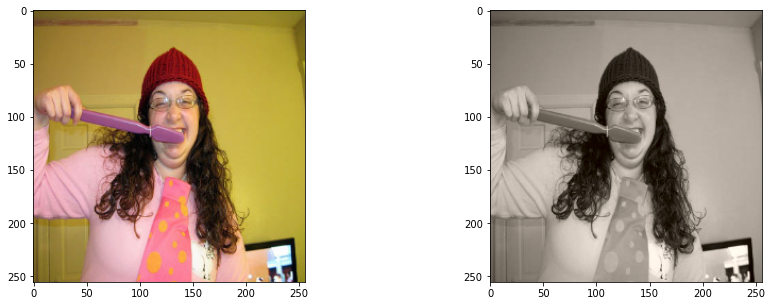

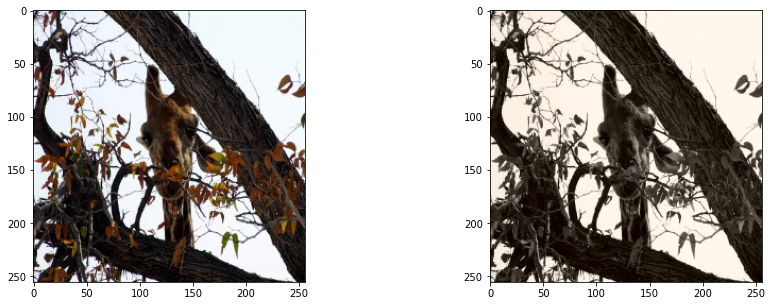

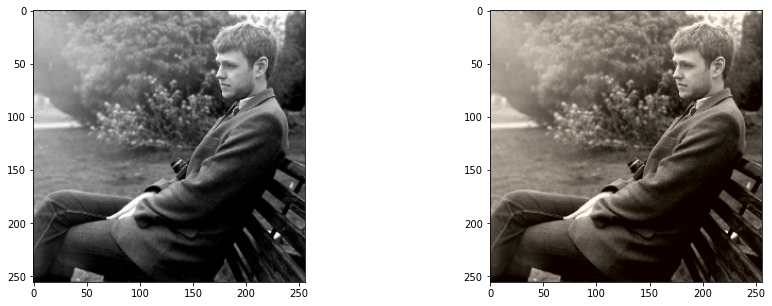

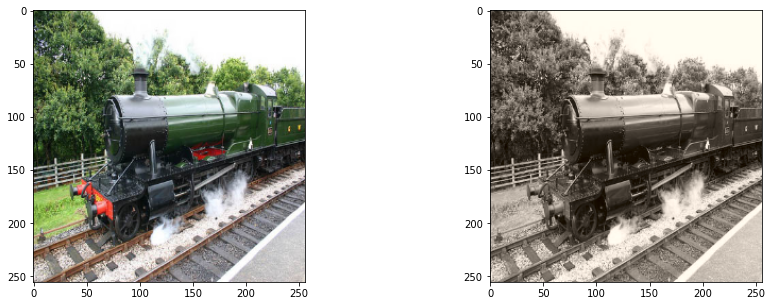

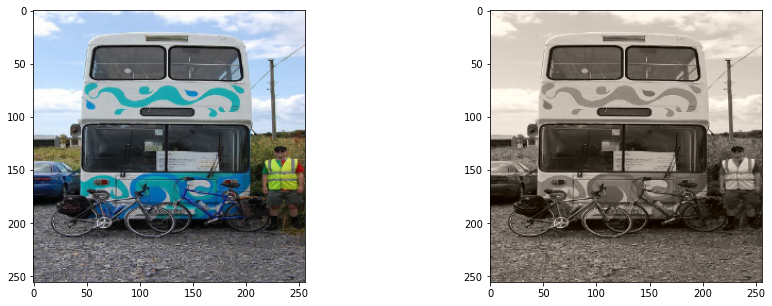

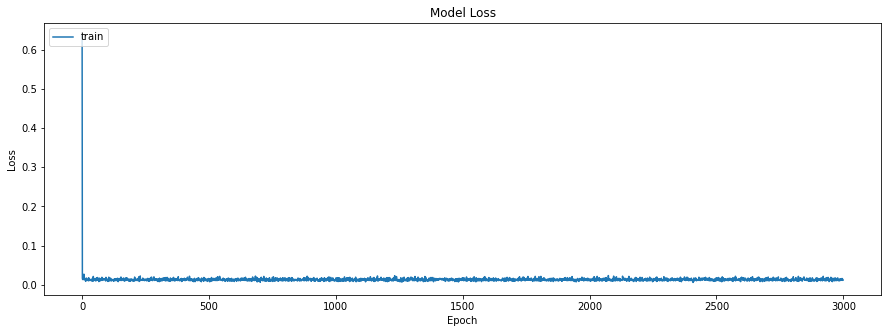

In [ ]:
#################################################################
# Stats Train
#################################################################
#Make a prediction on the unseen images
color_me = []
cnt = 0
num_images_test = 1

for filename in os.listdir(data_dat + 'test_color/'):
  if cnt < 5:      
    color_me.append(resize(img_to_array(load_img(data_dat + 'test_color/'+filename)), (256, 256)))
    cnt += 1



color_me = np.array(color_me, dtype=float)
color_me = 1.0/255*color_me
imagenes = color_me
color_me = gray2rgb(rgb2gray(color_me))
color_me_embed = create_inception_embedding(color_me)
color_me = rgb2lab(color_me)[:,:,:,0]
color_me = color_me.reshape(color_me.shape+(1,))


  # Test model
output = model.predict([color_me, color_me_embed])
output = output * 128

# Output colorizations
for i in range(len(output)):    
    cur = np.zeros((256, 256, 3))
    cur[:,:,0] = color_me[i][:,:,0]
    cur[:,:,1:] = output[i]
    #plt.imshow(cur * 255.0)
    #plt.imshow(lab2rgb(cur) * 255.0) 
    #imsave(input_folder + 'result/img_'+str(i)+".png", lab2rgb(cur)  
    #cv2_imshow(color_me[i])
    #cv2_imshow(lab2rgb(cur) * 255.0)
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    axs[0].imshow(imagenes[i])
    axs[1].imshow(lab2rgb(cur))
    plt.show()



plot_folder = input_folder + 'plot'

fig, axs = plt.subplots(1,1,figsize=(15,5)) 
# summarize history for accuracy
#axs[0].plot(history.history['accuracy']) 
#axs[0].plot(history.history['val_accuracy']) 
#axs[0].set_title('Model Accuracy')
#axs[0].set_ylabel('Accuracy') 
#axs[0].set_xlabel('Epoch')
    
#axs[0].legend(['train', 'validate'], loc='upper left')
# summarize history for loss
axs.plot(history.history['loss']) 
#axs[0].plot(history.history['val_loss']) 
axs.set_title('Model Loss')
axs.set_ylabel('Loss') 
axs.set_xlabel('Epoch')
axs.legend(['train'], loc='upper left')
#plt.savefig(plot_folder + 'res_image_irony.png')
plt.show()